# Encontro 13: Medidas de Centralidade

Importando a biblioteca:

In [140]:
import sys
sys.path.append('..')

from random import choice
import pandas as pd
import scipy
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import socnet as sn

Configurando a biblioteca:

In [141]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

Carregando rede de casamentos entre famílias de Florença durante a Renascença.

J. F. Padgett e C. K. Ansell. *Robust action and the rise of the Medici, 1400–1434.* American Journal of
Sociology 98, págs. 1259-1319, 1993.

In [142]:
g = sn.load_graph('Renaissance.gml', has_pos=True)

sn.show_graph(g, nlab=True)

Função que registra, em cada nó, seus sucessores em geodésicas de $s$ a $t$.

ps: Geodésica é o menor caminho possível que liga dois nós em um grafo.

In [143]:
def set_geodesic_successors(g, s, t):
    for n in g.nodes:
        g.nodes[n]['geodesic_successors'] = set()

    for p in nx.all_shortest_paths(g, s, t):
        for i in range(len(p) - 1):
            g.nodes[p[i]]['geodesic_successors'].add(p[i + 1])

Funções que representam uma escolha aleatória de sucessor para diferentes tipos de trajetórias.

In [144]:
# Pense que o atributo 'passages' abaixo indica quantas
# vezes um fluxo já passou por um nó ou por uma aresta.

def random_geodesic_successor(g, n):
    return choice([m for m in g.nodes[n]['geodesic_successors']])

def random_path_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.nodes[m]['passages'] == 0])

def random_trail_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.edges[n, m]['passages'] == 0])

def random_walk_successor(g, n):
    return choice([m for m in g.neighbors(n)])

Função que faz uma simulação de fluxo de $s$ a $t$, que pode ou não ser bem-sucedida.

In [145]:
def simulate_single_flow(g, s, t, sucessor_type, diffusion_type):
    # Inicializa o atributo 'passages' de cada nó.
    for n in g.nodes:
        g.nodes[n]['passages'] = 0
    g.nodes[s]['passages'] = 1

    # Inicializa o atributo 'passages' de cada aresta.
    for n, m in g.edges:
        g.edges[n, m]['passages'] = 0

    # Inicializa s como o único dono do insumo.
    for n in g.nodes:
        g.nodes[n]['owner'] = False
    g.nodes[s]['owner'] = True

    # Simula o fluxo, contando o número total de passos.

    steps = 0

    while True:
        # O conjunto reached representa todos os nós
        # que o fluxo consegue alcançar no passo atual.
        reached = set()

        # Verifica cada um dos donos atuais do insumo.

        owners = [n for n in g.nodes if g.nodes[n]['owner']]

        for n in owners:
            # Escolhe aleatoriamente um dos sucessores.
            try:
                if sucessor_type == "geodesic":
                    m = random_geodesic_successor(g, n)
                    
                if sucessor_type == "path":
                    m = random_path_successor(g, n)
                    
                if sucessor_type == "trail":
                    m = random_trail_successor(g, n)
                    
                if sucessor_type == "walk":
                    m = random_walk_successor(g, n)
                    
            except IndexError:
                continue

            if diffusion_type == "duplication":
                # Continua a ser dono do insumo.
                g.nodes[n]['owner'] = True
            if diffusion_type == "transfer":
                # Deixa de ser dono do insumo.
                g.nodes[n]['owner'] = False
                
            # Incrementa o atributo 'passages' do nó.
            g.nodes[m]['passages'] += 1

            # Incrementa o atributo 'passages' da aresta.
            g.edges[n, m]['passages'] += 1

            # Registra que consegue alcançar esse nó.
            reached.add(m)

        # Todo nó alcançado passa a ser dono do insumo.

        for n in reached:
            g.nodes[n]['owner'] = True

        # Isso conclui o passo atual da simulação.
        steps += 1

        # Se o passo alcançou t, chegamos ao fim da simulação.
        # Ela foi bem-sucedida: devolvemos o número de passos.
        if t in reached:
            return steps

        # Se o passo não alcançou ninguém, chegamos ao fim da
        # simulação. Ela não foi bem-sucedida: devolvemos -1.
        if not reached:
            return -1

Função que faz simulações de fluxo de $s$ a $t$ até uma ser bem-sucedida.

In [146]:
def simulate_successful_flow(g, s, t, sucessor_type, diffusion_type):
    set_geodesic_successors(g, s, t)

    while True:
        steps = simulate_single_flow(g, s, t, sucessor_type, diffusion_type)

        if steps != -1:
            return steps

Função que faz simulações de fluxo para todo $s$ e $t$ possíveis, e tira disso um *closeness simulado* e um *betweenness simulado*.

In [147]:
def simulate_all_flows(g, sucessor_type, diffusion_type):
    for n in g.nodes:
        g.nodes[n]['closeness'] = 0
        g.nodes[n]['betweenness'] = 0

    for s, t in permutations(g.nodes, 2):
        steps = simulate_successful_flow(g, s, t, sucessor_type, diffusion_type)

        g.nodes[s]['closeness'] += steps
        for n in g.nodes:
            if n != s and n != t:
                g.nodes[n]['betweenness'] += g.nodes[n]['passages']

    # Normalizações necessárias para comparar com os
    # resultados analíticos. Não é preciso entender.
    for n in g.nodes:
        g.nodes[n]['closeness'] = (g.number_of_nodes() - 1) / g.nodes[n]['closeness']
        g.nodes[n]['betweenness'] /= (g.number_of_nodes() - 1) * (g.number_of_nodes() - 2)

Média de *closeness simulado* e *betweenness simulado* para muitas repetições da simulação acima.

In [148]:
TIMES = 100

sucessor_type = ["geodesic", "path", "trail", "walk"]
diffusion_type = ["transfer", "duplication"]

for n in g.nodes:
    g.nodes[n]['mean_closeness'] = 0
    g.nodes[n]['mean_betweenness'] = 0

for _ in range(TIMES):
    simulate_all_flows(g, sucessor_type[0], diffusion_type[1])

    for n in g.nodes:
        g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
        g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']

for n in g.nodes:
    g.nodes[n]['mean_closeness'] /= TIMES
    g.nodes[n]['mean_betweenness'] /= TIMES

Cálculo de *closeness* e *betweenness* a partir das funções prontas da NetworkX, para comparação.

In [149]:
cc = nx.closeness_centrality(g)
bc = nx.betweenness_centrality(g)

Construção de data frame só para comparar mais facilmente.

In [150]:
pd.DataFrame({
    'família': [g.nodes[n]['label'] for n in g.nodes],
    'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
    'closeness analítico': [cc[n] for n in g.nodes],
    'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
    'betweenness analítico': [bc[n] for n in g.nodes],
})

,família,closeness simulado,closeness analítico,betweenness simulado,betweenness analítico
0,ginori,0.333333,0.333333,0.000000,0.000000
1,lambertes,0.325581,0.325581,0.000000,0.000000
2,albizzi,0.482759,0.482759,0.566209,0.212454
3,guadagni,0.466667,0.466667,0.687747,0.260073
4,pazzi,0.285714,0.285714,0.000000,0.000000
5,salviati,0.388889,0.388889,0.406593,0.142857
6,medici,0.560000,0.560000,1.388901,0.521978
7,tornabuon,0.482759,0.482759,0.249121,0.091575
8,bischeri,0.400000,0.400000,0.314176,0.120879
9,ridolfi,0.482759,0.482759,0.249176,0.086081


E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

In [167]:
TIMES = 100

sucessor_type = ["geodesic", "path", "trail", "walk"]
diffusion_type = ["transfer", "duplication"]
families = ["ginori", "lambertes", "albizzi", "guadagni", "pazzi", "salviati", "medici", "tornabuon", "bischeri", "ridolfi", "acciaiuol", "strozzi", "peruzzi", "barbadori", "castellan"]
data_list = []

def createList():
    list = []
    for i in diffusion_type:
        list.append([])
        
        for j in sucessor_type:
            list[diffusion_type.index(i)].append([])
            
            for k in families:
                list[diffusion_type.index(i)][sucessor_type.index(j)].append([])
    return list

amostras_closeness = createList()
amostras_betweenness = createList()

# amostras_closeness = [[[],[]],[[],[]],[[],[]],[[],[]]]
# amostras_betweenness = [[[],[]],[[],[]],[[],[]],[[],[]]]
w = sn.load_graph('Renaissance.gml', has_pos=True)

for t in diffusion_type:
    for i in sucessor_type:
        g = w.copy()
        for n in g.nodes:
            g.nodes[n]['mean_closeness'] = 0
            g.nodes[n]['mean_betweenness'] = 0

        for _ in range(TIMES):
            simulate_all_flows(g, sucessor_type[sucessor_type.index(i)], diffusion_type[diffusion_type.index(t)])
            
            c = 0
            for n in g.nodes:
                g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
                amostras_closeness[diffusion_type.index(t)][sucessor_type.index(i)][c].append(g.nodes[n]['closeness'])
                #amostras_closeness[0][0][c].append(g.nodes[n]['closeness'])
                
                g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']
                amostras_betweenness[diffusion_type.index(t)][sucessor_type.index(i)][c].append(g.nodes[n]['betweenness'])
                #amostras_betweenness[0][0][c].append(g.nodes[n]['betweenness'])
                c += 1
        for n in g.nodes:
            g.nodes[n]['mean_closeness'] /= TIMES
            g.nodes[n]['mean_betweenness'] /= TIMES

        cc = nx.closeness_centrality(g)

        bc = nx.betweenness_centrality(g)

        data = pd.DataFrame({
            'família': [g.nodes[n]['label'] for n in g.nodes],
            'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
            'closeness analítico': [cc[n] for n in g.nodes],
            'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
            'betweenness analítico': [bc[n] for n in g.nodes],
            'sucessor type': i,
            'diffusion_type': t
        })

        data.name = i
        data_list.append(data)

In [168]:
print(len(amostras_betweenness[0][0][0]))

100


In [189]:
result = pd.concat(data_list, ignore_index=True)
result

,família,closeness simulado,closeness analítico,betweenness simulado,betweenness analítico,sucessor type,diffusion_type
0,ginori,0.333333,0.333333,0.000000,0.000000,geodesic,transfer
1,lambertes,0.325581,0.325581,0.000000,0.000000,geodesic,transfer
2,albizzi,0.482759,0.482759,0.211648,0.212454,geodesic,transfer
3,guadagni,0.466667,0.466667,0.253736,0.260073,geodesic,transfer
4,pazzi,0.285714,0.285714,0.000000,0.000000,geodesic,transfer
5,salviati,0.388889,0.388889,0.142857,0.142857,geodesic,transfer
6,medici,0.560000,0.560000,0.524011,0.521978,geodesic,transfer
7,tornabuon,0.482759,0.482759,0.087912,0.091575,geodesic,transfer
8,bischeri,0.400000,0.400000,0.121209,0.120879,geodesic,transfer
9,ridolfi,0.482759,0.482759,0.090769,0.086081,geodesic,transfer


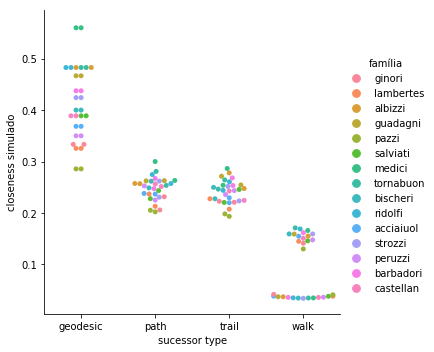

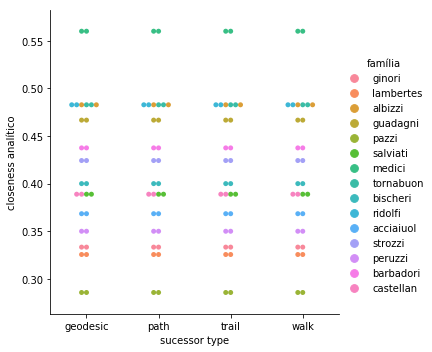

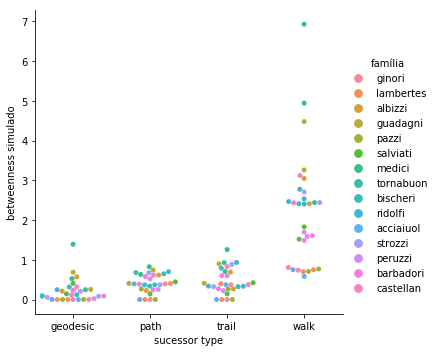

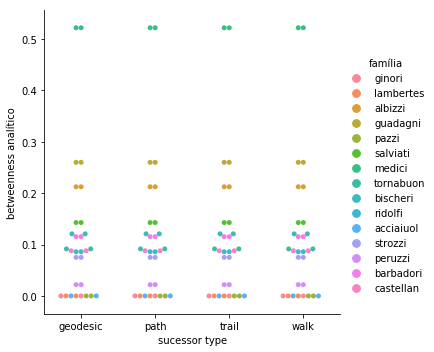

In [170]:
def plot_hist(rel1, rel2):
    sns.catplot(x=rel1, y=rel2, hue="família", kind="swarm", data=result)
    
plot_hist("sucessor type", "closeness simulado")
plot_hist("sucessor type", "closeness analítico")
plot_hist("sucessor type", "betweenness simulado")
plot_hist("sucessor type", "betweenness analítico")

In [171]:
benchmark  = amostras_closeness[0][0] #Geodesic Transfer
path_t     = data_list[1]
trail_t    = data_list[2]
walk_t     = data_list[3]
geodesic_d = data_list[4]
path_d     = data_list[5]
trail_d    = data_list[6]
walk_d     = data_list[7]

In [213]:
from scipy.stats import ttest_ind

def get_mean_by_samples(amostra, variable):
    for i in range(len(diffusion_type)):
        for j in range(len(sucessor_type)):
            print("\n")
            for k in range(len(families)):
                if i == 0 and j == 0:
                    pass
                else:
                    result = scipy.stats.ttest_ind(amostra[i][j][k], amostra[0][0][k] , equal_var=False)
                    print("[{}] = DT: {} - ST: {} - F: {}  ".format(variable, diffusion_type[i], sucessor_type[j], families[k]), "t-value: ", round(result[0], 5), "p-value: ", round(result[1], 8))

In [214]:
get_mean_by_samples(amostras_closeness, "Closeness")





[Closeness] = DT: transfer - ST: path - F: ginori   t-value:  -49.09771 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: lambertes   t-value:  -42.59653 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: albizzi   t-value:  -52.35603 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: guadagni   t-value:  -56.643 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: pazzi   t-value:  -38.73531 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: salviati   t-value:  -56.11627 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: medici   t-value:  -56.94757 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: tornabuon   t-value:  -63.64173 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: bischeri   t-value:  -51.59991 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: ridolfi   t-value:  -70.23218 p-value:  0.0
[Closeness] = DT: transfer - ST: path - F: acciaiuol   t-value:  -45.47236 p-value:  0.0
[Closeness] = DT: transfer - ST: pat

In [215]:
get_mean_by_samples(amostras_betweenness, "Betweenness")





[Betweenness] = DT: transfer - ST: path - F: ginori   t-value:  nan p-value:  nan
[Betweenness] = DT: transfer - ST: path - F: lambertes   t-value:  nan p-value:  nan
[Betweenness] = DT: transfer - ST: path - F: albizzi   t-value:  6.04763 p-value:  1e-08
[Betweenness] = DT: transfer - ST: path - F: guadagni   t-value:  54.14223 p-value:  0.0
[Betweenness] = DT: transfer - ST: path - F: pazzi   t-value:  nan p-value:  nan
[Betweenness] = DT: transfer - ST: path - F: salviati   t-value:  0.0 p-value:  1.0
[Betweenness] = DT: transfer - ST: path - F: medici   t-value:  38.51399 p-value:  0.0
[Betweenness] = DT: transfer - ST: path - F: tornabuon   t-value:  69.19373 p-value:  0.0
[Betweenness] = DT: transfer - ST: path - F: bischeri   t-value:  83.57155 p-value:  0.0
[Betweenness] = DT: transfer - ST: path - F: ridolfi   t-value:  82.69589 p-value:  0.0
[Betweenness] = DT: transfer - ST: path - F: acciaiuol   t-value:  nan p-value:  nan
[Betweenness] = DT: transfer - ST: path - F: st

In [159]:
result[["família", "closeness simulado", "closeness analítico", "sucessor type", "diffusion_type"]].sort_values(by=['família'], ascending=False)

,família,closeness simulado,closeness analítico,sucessor type,diffusion_type
37,tornabuon,0.248405,0.482759,trail,transfer
82,tornabuon,0.284288,0.482759,path,duplication
52,tornabuon,0.035708,0.482759,walk,transfer
97,tornabuon,0.264585,0.482759,trail,duplication
7,tornabuon,0.482759,0.482759,geodesic,transfer
112,tornabuon,0.172372,0.482759,walk,duplication
67,tornabuon,0.482759,0.482759,geodesic,duplication
22,tornabuon,0.255382,0.482759,path,transfer
41,strozzi,0.231890,0.424242,trail,transfer
26,strozzi,0.238434,0.424242,path,transfer


In [90]:
result[["família", "betweenness simulado", "betweenness analítico", "sucessor type", "diffusion_type"]].sort_values(by=['betweenness simulado'], ascending=False)

,família,betweenness simulado,betweenness analítico,sucessor type,diffusion_type
111,medici,6.783022,0.521978,walk,duplication
51,medici,5.042143,0.521978,walk,transfer
108,guadagni,4.430659,0.260073,walk,duplication
48,guadagni,3.319560,0.260073,walk,transfer
119,castellan,3.077033,0.087912,walk,duplication
107,albizzi,3.033352,0.212454,walk,duplication
113,bischeri,2.710824,0.120879,walk,duplication
116,strozzi,2.665165,0.075092,walk,duplication
54,ridolfi,2.509451,0.086081,walk,transfer
52,tornabuon,2.506484,0.091575,walk,transfer


Na tabela 1, onde o closeness simulado está ordenado na ordem descrescente, temos que os maiores closeness simulado  das famílias 

Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior closeness simulado e betweenness simulado não são necessariamente os nós com maior closeness e betweenness segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

    Em outros tipos de trajetória e difusão, os nós com maior closeness simulado e betweeness simulado NÃO são NECESSÁRIAMENTE os nós com maior closeness e betweennes que o benchmark.

In [109]:
for i in data_list:
    print(i.name, i["diffusion_type"][0], "\n", i["betweenness simulado"].describe(), "\n")

geodesic transfer 
 count    15.000000
mean      0.115751
std       0.136504
min       0.000000
25%       0.010659
50%       0.088132
75%       0.131951
max       0.522418
Name: betweenness simulado, dtype: float64 

path transfer 
 count    15.000000
mean      0.246875
std       0.187480
min       0.000000
25%       0.071429
50%       0.248352
75%       0.366291
max       0.628022
Name: betweenness simulado, dtype: float64 

trail transfer 
 count    15.000000
mean      0.248396
std       0.195819
min       0.000000
25%       0.071429
50%       0.268681
75%       0.341786
max       0.704121
Name: betweenness simulado, dtype: float64 

walk transfer 
 count    15.000000
mean      2.067143
std       1.169014
min       0.714780
25%       1.165412
50%       2.455549
75%       2.493489
max       5.042143
Name: betweenness simulado, dtype: float64 

geodesic duplication 
 count    15.000000
mean      0.311956
std       0.364391
min       0.000000
25%       0.028214
50%       0.250000
75%   

In [106]:
for i in data_list:
    print(i.name, i["diffusion_type"][0], "\n", i["closeness simulado"].describe(), "\n")

geodesic transfer 
 count    15.000000
mean      0.411834
std       0.074293
min       0.285714
25%       0.359211
50%       0.400000
75%       0.474713
max       0.560000
Name: closeness simulado, dtype: float64 

path transfer 
 count    15.000000
mean      0.243833
std       0.026561
min       0.202618
25%       0.233339
50%       0.243448
75%       0.254012
max       0.311044
Name: closeness simulado, dtype: float64 

trail transfer 
 count    15.000000
mean      0.238894
std       0.023713
min       0.196947
25%       0.224820
50%       0.240312
75%       0.252768
max       0.283948
Name: closeness simulado, dtype: float64 

walk transfer 
 count    15.000000
mean      0.036515
std       0.001783
min       0.034301
25%       0.035362
50%       0.035708
75%       0.037626
max       0.040086
Name: closeness simulado, dtype: float64 

geodesic duplication 
 count    15.000000
mean      0.411834
std       0.074293
min       0.285714
25%       0.359211
50%       0.400000
75%       0.47